In [1]:
import numpy as np
import pandas as pd

#displaying images
from PIL import Image
import IPython.display
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

#neural network
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD


from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.normalization import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.regularizers import l2
from keras.callbacks import EarlyStopping




Using TensorFlow backend.


### Image Classification with Convolutional Neural Networks vs Classic Machine Learning Algorithms
     
     ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


**In this project I will be looking at a dataset of 28x28 pixel images of different articles of clothing. There are 9 different possible class of clothing, My objective is to do imaeg classification, first using neural networks, and then comparing the classification results I was able to achieve with different classic machine learning models. Finally, I will make predictions.**

To begin, I loaded in the csv files (xtrain, xtest, ytrain, ytest) and visualized the data. I then did a bit of data preporcessing.

In [3]:
xtrain = np.loadtxt('xtrain.csv')
xtest = np.loadtxt('xtest.csv')
ytrain = np.loadtxt('ytrain.csv')
ytest = np.loadtxt('ytest.csv')

print(xtrain.shape, xtest.shape , ytrain.shape, ytest.shape)

#copying to use for question 2, not necessary, but it is helpful for me to keep it separate and organized
xtrainCopy = xtrain
ytrainCopy = ytrain
xtestCopy = xtest
ytestCopy = ytest

xtrain1 = xtrain.reshape((xtrain.shape[0], 28,28))
print(xtrain1.shape)

(47520, 784) (6480, 784) (47520,) (6480,)
(47520, 28, 28)


**This dataset consists of 47,520 training samples and 6,480 test samples. Each example is a 28x28 grayscale image, associated with a label from 1 of 9 possible classes. **

<li>d) Use at least 3 regularization techniques to improve the accuracy of the network you designed in part (a). Describe the improvement in the classification accuracy that you get from each technique. Explain why each technique worked or did not work.  <br>
<li>e) Augment the training dataset (x2 and x3) and test your model. Which augmentation methods did you use? Explain why it did or did not improve the accuracy.  <br>

**For part c, d, and e, plot the loss function and accuracy**



**First, I am visualizing the data in images, providing 5 samples per class.**

In [4]:
#getting all of the possible classes into an array
possibleClasses = np.unique(ytrain)

minClass = min(possibleClasses)

The following will produce a 9x5 grid with each row showing 5 examples of a class. There are 9 classes total.

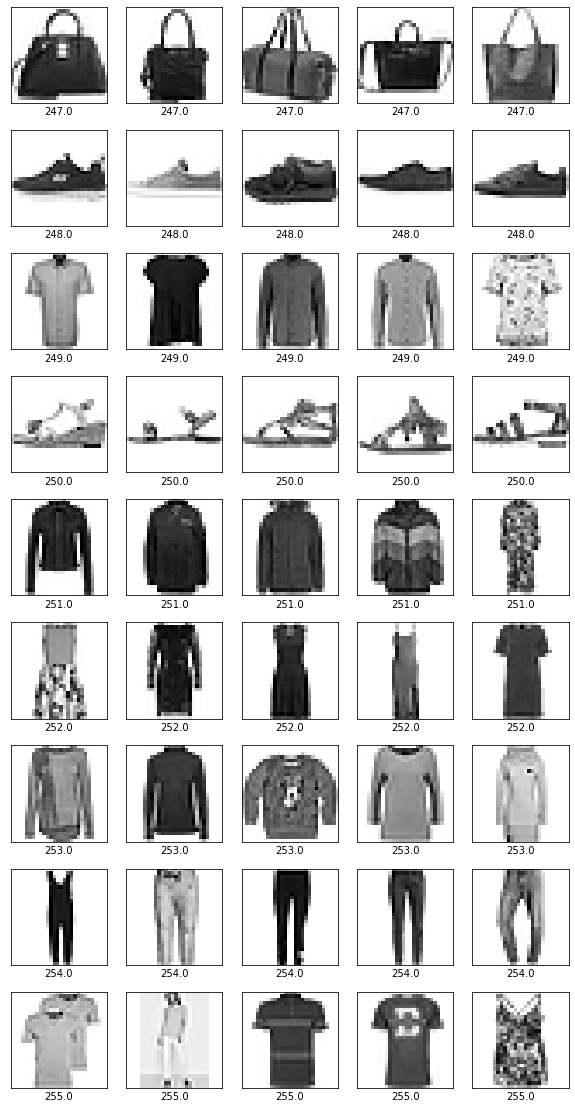

In [5]:
#puts all 9 possible classes into an array
numClasses = len(possibleClasses)
classCount = 0
totalCount = 0
plt.figure(figsize=(10,20)) 

#This loop gets the indexes of 5 examples of each class and plots them in subplots
#Each row of the subplot grid will show 5 examples from a different class
for c in possibleClasses:    
    exampleCount = 0
    
    for i in range(len(xtrain1)):
        if ytrain[i] == c: 
            exampleCount += 1
            plt.subplot(len(possibleClasses),5,totalCount+1)
            plt.grid(False)
            plt.imshow(np.asarray(xtrain1[i]), cmap='gray')
            plt.xlabel(ytrain[i])
            plt.xticks([])
            plt.yticks([])
            totalCount += 1
            
            #breaks after getting 5 examples from a single class
            if exampleCount == 5:
                break
    classCount += 1
    
plt.show()

**Next, I am taking steps to preprocess the data**

To preprocess the data, I am making sure that there are no misisng values. I then look at the data to see what each row looks like and make sure that they are all consistent. If not (and a column has its values between 0 and 1), I multiply by 255. However, this was not the case for any row.

In [6]:
# Checking for nans or nulls in the data set
# There were no nans or nulls
df = pd.DataFrame(xtrain, ytrain)
df.isna().sum().sum()
df.isnull().sum().sum()


# VISUALIZE THE DATA
# xtrain[0] shows that all of the numbers are 255 or below. 
xtrain[0]


#check that all values are scaled the same. if they are between 0 and 1, multiply by 255
for i in range(len(xtrain)):
    if max(xtrain[i]) <= 1:
        xtrain[i] = xtrain[i] * 255.0
        
for i in range(len(xtest)):
    if max(xtest[i]) <= 1:
        xtest[i] = xtest[i] * 255.0
        


I then normalize the data and divide both X train and test by 255 to get the pixel values between 0 and 1. I also reshape the X data to 28x28. For y test and train, I change the classes to 0 to 8 by subtracting the minimum class value. 

In [7]:
# I will divide all of the data by 255 in order to get them to be between 0 and 1/ normalize data 
xtest.dtype
xtrain.dtype

#maybe
xtrain = xtrain.reshape(len(xtrain), 28, 28, 1) 
xtest = xtest.reshape(len(xtest), 28, 28, 1) 

xtest /= 255.0
xtrain /= 255.0
ytest -= min(ytest)
ytrain -= min(ytrain)

ytrain = keras.utils.to_categorical(ytrain, numClasses)
ytest = keras.utils.to_categorical(ytest, numClasses)

#reshaping the data for an image
#xtrain = xtrain.reshape((xtrain.shape[0], 28,28))
#xtest = xtest.reshape((xtest.shape[0], 28,28))

# Here, I am mapping the classes to their descriptions, based on what I see in the grid above. Not sure if it will be of use yet.
categoryMap = {255: "shirt", 254: "jeans", 253: "long sleeve shirt", 252: "dress", 251: "outerwear shirt", 250: "sandall", 249: "button down", 248: "sneakers", 247: "purse"}

xtrain.shape
ytrain.shape

(47520, 9)

**Constructing and training the neural network using Keras.**

I constructed my model as a Convolution Neural Network. I chose a CNN because they are optimal for image analysis.
To construct my model, I began by creating a basic model of the VGG structure, which is generally a good starting point. I then tested out different amounts of filters for each layer to see what was optimal for my data. I kept the filters sizes at 3x3 becuase the imagees are relatively small. 
I added Max pooling layers after the two set of convolution layers as this does dimensionality reduction and reduces the features, taking the max the maximum among pixels. It. basically results in a more condensed features for the following layers.

I then added on another set of convolutional layers along with max pooling which improved my model. Again, I tested out the filters to find what was optimal, starting with the ones I had above. I again added a max pooling layer. 

Finally, I added one fully connected layer where I set the filter to 128 and then the output layer.

To each convolution layer I added padding = same because this pads the images with zeros for more full processing.
I also set the kernel initializer to he_normal.

In [17]:
baseModel = Sequential()
baseModel.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
baseModel.add(Conv2D(64, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
baseModel.add(MaxPooling2D((2, 2)))
baseModel.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
baseModel.add(Conv2D(128, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
baseModel.add(MaxPooling2D((2, 2)))
baseModel.add(Flatten())
baseModel.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
baseModel.add(Dense(9, activation = 'softmax'))
baseModel.compile(loss='categorical_crossentropy', optimizer=SGD(lr = .05), metrics=['accuracy']) 
history = baseModel.fit(xtrain, ytrain, batch_size=64, epochs=20, validation_data=(xtest, ytest), verbose = 0) 

In [54]:
_, acc = baseModel.evaluate(xtest, ytest, verbose=0)
print('Accuracy after 20 epochs: %.3f' % (acc * 100.0))

Accuracy after 20 epochs: 92.485


**After 20 epochs my accuracy score was 92.49, which is pretty good! However, according to the graph, it appears that the model may have high variance because it appears to be very over fit to the training set. As we increase epochs, the (after about epoch 3), our training and testing accuracy start to diverge- the training accuracy continues to increase while the testing accuracy stays stable, or at least increases at a much slower rate. You can see the same thing in the loss function plot where after about 3 epochs, loss starts to increase for the validation set. This overfitting tells me that although I reached an accuracy of > 92%, there is still room for improvement.**

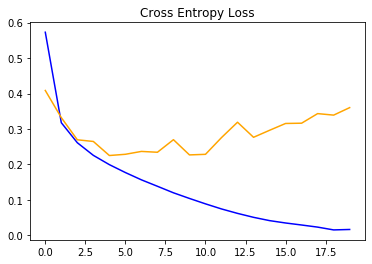

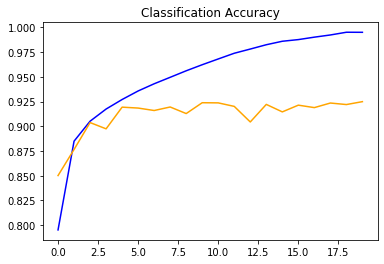

In [24]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()


# plot accuracy
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()



**Improving The Model**

The first thing I did to improve my model was dropout regularization. I tested it on just the convolution layers, as well as soley on the fully connected layer, but neither of these methods were as effective as adding dropout in all three of these areas. Dropout was working very well, so I adjusted the levels at each point and increasing as I moved down layers, but .2 at each layer seemed to work best for this model. The validation accuracy after 20 epochs was 93.349%.

Using dropout regularization the model improved from 92.485 (base model) to 93.349 (base model + dropout). We can also see in the graph that the training set and testing set diverge much less, showing that there was some correcting to problem of overfitting.

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.2))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.2))


model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(.2))


model.add(Dense(9, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr = .05), metrics=['accuracy']) 
history1 = model.fit(xtrain, ytrain, batch_size=64, epochs=20, validation_data=(xtest, ytest), verbose = 0) 


In [53]:
_, acc = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy after 20 epochs: %.3f' % (acc * 100.0))

Accuracy after 20 epochs: 93.349


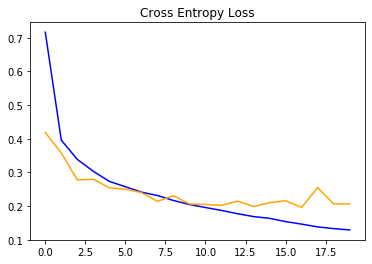

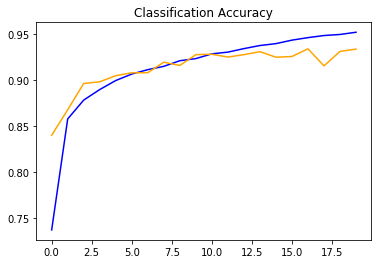

In [30]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(history1.history['loss'], color='blue', label='train')
plt.plot(history1.history['val_loss'], color='orange', label='test')
plt.show()

# plot accuracy
plt.title('Classification Accuracy')
plt.plot(history1.history['accuracy'], color='blue', label='train')
plt.plot(history1.history['val_accuracy'], color='orange', label='test')
plt.show()

I then tried to use weigh decay methods, L1 and L2. Neither of these methods improved the accuracy when combined with drop out. With L2 at .001, as shown as an example below, you can see that the model had an accuracy of 92.253. This is down from the base model accuracy of 92.485 and the base + dropout model accuracy of 93.349. Thus, I will not be using weight decay regularization for my improved final model.

In [32]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model1.add(Conv2D(64, (3,3), activation ='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(.2))


model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model1.add(Conv2D(128, (3,3), activation ='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(.2))


model1.add(Flatten())
model1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dropout(.2))


model1.add(Dense(9, activation = 'softmax'))
model1.compile(loss='categorical_crossentropy', optimizer=SGD(lr = .05), metrics=['accuracy']) 
history2 = model1.fit(xtrain, ytrain, batch_size=64, epochs=20, validation_data=(xtest, ytest), verbose = 0) 

In [52]:
_, acc = model1.evaluate(xtest, ytest, verbose=0)
print('Accuracy after 20 epochs: %.3f' % (acc * 100.0))

Accuracy after 20 epochs: 92.253


Next, I added batch normalization. Batch normalization kept the accuracy of my model pretty much the same. The accuracy shows that it is slightly lower, but because we are using SDG, the accuracies may fluctuate as they grow, so the final accuracy may not be representative of the improvement that batch normalization is making. Batch normalization was added for the purpose of speeding up the training, with a possibility of improving the model, so with that information, I will keep it in my final model, as it should be helpful. The drop was likely do to the training stopping at a minimum, and thus causing some overfitting.

In [57]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model2.add(BatchNormalization())


model2.add(Conv2D(64, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())


model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(.2))


model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model2.add(BatchNormalization())


model2.add(Conv2D(128, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())


model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(.2))


model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())


model2.add(Dropout(.2))


model2.add(Dense(9, activation = 'softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=SGD(lr = .05), metrics=['accuracy']) 
history3 = model2.fit(xtrain, ytrain, batch_size=64, epochs=20, validation_data=(xtest, ytest), verbose = 0) 



In [58]:
_, acc = model2.evaluate(xtest, ytest, verbose=0)
print('Accuracy after 20 epochs: %.3f' % (acc * 100.0))

Accuracy after 20 epochs: 93.117


The last step I will take to improve my model is increase the number of epochs to allow for more training time. I set the model to train for 100 epochs but also included the regularization technique of early stopping. You can see in the previous plot that the accuracy and loss of the test set trend in a certain direction, but fluctuate (which is normal of SGD). If the training ends on one of the minimums, this can cause overfitting. So I will use early stopping in attempt to prevent this. I used a patience of 25 in order to allow some fluctuations so that the model can continue to train a good amount, but will ultimately stop after loss increases 25 times. 

My final model, with increased epochs + early stopping + batch normalization + dropout had an accuracy of 93.781 compared to the base model which has an accuracy of 92.485. You can also see in the graph that there is still some over fitting, but perhaps not as much. The loss seems to plateau more at a certain point instead of increase. 

In [24]:
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=25,
                              verbose=0, mode='auto')


modelImp = Sequential()
modelImp.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
modelImp.add(BatchNormalization())


modelImp.add(Conv2D(64, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
modelImp.add(BatchNormalization())


modelImp.add(MaxPooling2D((2, 2)))
modelImp.add(Dropout(.2))


modelImp.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
modelImp.add(BatchNormalization())


modelImp.add(Conv2D(128, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
modelImp.add(BatchNormalization())


modelImp.add(MaxPooling2D((2, 2)))
modelImp.add(Dropout(.2))


modelImp.add(Flatten())
modelImp.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelImp.add(BatchNormalization())


modelImp.add(Dropout(.2))


modelImp.add(Dense(9, activation = 'softmax'))
modelImp.compile(loss='categorical_crossentropy', optimizer=SGD(lr = .05), metrics=['accuracy']) 
historyImprovedModel = modelImp.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xtest, ytest), verbose = 0, callbacks=[es]) 



In [25]:
_, acc = modelImp.evaluate(xtest, ytest, verbose=0)
print('Accuracy of final model: %.3f' % (acc * 100.0))



Accuracy of final model: 93.781


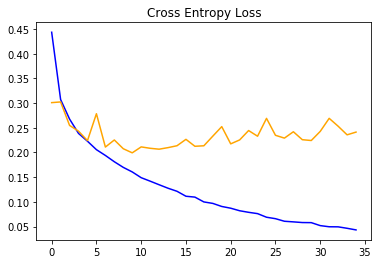

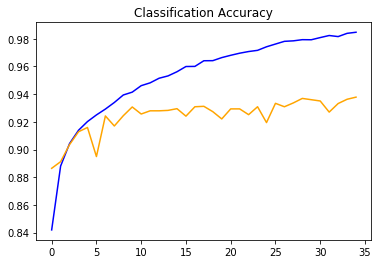

In [26]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(historyImprovedModel.history['loss'], color='blue', label='train')
plt.plot(historyImprovedModel.history['val_loss'], color='orange', label='test')
plt.show()


# plot accuracy
plt.title('Classification Accuracy')
plt.plot(historyImprovedModel.history['accuracy'], color='blue', label='train')
plt.plot(historyImprovedModel.history['val_accuracy'], color='orange', label='test')
plt.show()

Further improvement in the future: 
If I was to look into further imporving the model in the future, I think a good step would be to replace the optimizer with 'adam' instead of SGD. Adam converges faster, but sometimes it does not generalize as well as SGD, so it may cause move over fitting, but I believe it is worth trying out. However, often times people would start with adam and switch to SGD later, but although I started the other way around, I am still interested to see the affect it may have. I also think that increasing the "patience" level in early stopping could be benificial as it would allow more time for the training to be done, and maybe add a callback to make sure it improves before stopping or reaches a certain threshold.

**Data augmentation and expansion**

For data augemntation, I chose to use width shift which randomly shifts images horizontally, height shift which randomly shifts vertically, and horizontal flip which randomly flips images. I felt these transformations made the most sense for the clothing dataset. This is because the image may not be centered completely and also heights and widths of clothing may vary which would potentially be helped by heigh and width shift to pick up on different feaures in different areas of an image. Viewing them horizontally flipped could be usefull as well, but typically you would probably not see an artical of clothing worn or hung upside down, so a vertical flip, for instance, would likely not be of much benefit to us for classifying clothes. Lighting and color would also not aid us much as the images are grayscale. 

Also, I only wanted to augment the data slightly. We are working with relatively small images, so I think it is best to preserve the important features that the images have rather than distort them too much. We are also working with a pretty consistent set of data where all of the images look to be taken at a similar straight on angle. If these were images where they were taken from different angles or were maybe being worn on a person or mannequin, it would have been useful to use other augmentation techniques such as random zoom. 

I augmented the data and expanded the data set x2.

I trained my x2 augmented dataset for 60 epochs with early stopping. After the training stopped, the accuracy was 94.58. This was an improvment! On top of this, if you look at the graphs of accuracies and losses you can see that the overfitting is almost gone completely. It looks like it started off underfit, meaning it was too generalized or showing high bias. As epochs increased, however, this problem corrected itself and looks like a sweet spot was found with low bias and low variance right around when the training stopped. It actually could have been cut off a little earlier to decrease overfitting a little bit.

The improvement in accuracy makes a lot of sense. When we are training neural networks, they can only be trained well if we give them lots of data and lots of relevant data. A CNN will take in an image and look at all of its relevant features to classify them. In this dataset, for instance, we have one class of sneakers and a class of sandalls. Now these might look pretty similar because they are similar shapes, but to human eyes we can typically tell them apart. But for the CNN, what if every picture of sneakers was taken with the toe facing the right and every sandal with the toe facing the left side of image? Now, if we fed in a picture of a sandal, and this time it was facing right, the CNN may likely classify this as a sneaker because this may have been "learned" to be an important feature to classify it. Data augmentation, therefore, transforms the images slightly to add more variation to our dataset (in this final, the overall size was also increased) so that we have more and a larger variety of data fed into the nn. And when we have more valid data, our model will improve. In the case of the sneaker and sandal example I just gave, if we randomly applied horizontal flips to the data, then our CNN would learn what a sneaker and sandal look like in both directions and it is more likely going to correctly classify them and not mix the two up.

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)

xtrainx2 = np.concatenate((xtrain, xtrain))
ytrainx2 = np.concatenate((ytrain, ytrain))
xtrainx2.shape
ytrainx2.shape

xtrainx3 = np.concatenate((xtrainx2, xtrain))
ytrainx3 = np.concatenate((ytrainx2, ytrain))
xtrainx3.shape
#ytrainx3.shape

(142560, 28, 28, 1)

In [345]:
datagen.fit(xtrainx2)
iterator_train = datagen.flow(xtrainx2, ytrainx2, batch_size=64)


In [349]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=18, verbose=0, mode='auto')
modelAug = Sequential()
modelAug.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
modelAug.add(BatchNormalization())


modelAug.add(Conv2D(64, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
modelAug.add(BatchNormalization())


modelAug.add(MaxPooling2D((2, 2)))
modelAug.add(Dropout(.2))


modelAug.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
modelAug.add(BatchNormalization())


modelAug.add(Conv2D(128, (3,3), activation ='relu', padding='same', kernel_initializer='he_uniform'))
modelAug.add(BatchNormalization())


modelAug.add(MaxPooling2D((2, 2)))
modelAug.add(Dropout(.2))


modelAug.add(Flatten())
modelAug.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelAug.add(BatchNormalization())


modelAug.add(Dropout(.2))


modelAug.add(Dense(9, activation = 'softmax'))
modelAug.compile(loss='categorical_crossentropy', optimizer=SGD(lr = .05), metrics=['accuracy']) 

In [350]:
historyAug = modelAug.fit_generator(iterator_train, epochs=60, validation_data=(xtest, ytest), verbose=0, callbacks=[es])

In [353]:
_, acc = modelAug.evaluate(xtest, ytest, verbose=0)
print('Accuracy of final model with x2 Augmented Data: %.3f' % (acc * 100.0))

Accuracy of final model with x2 Augmented Data: 94.583


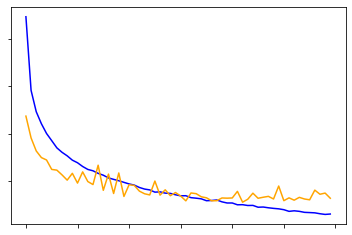

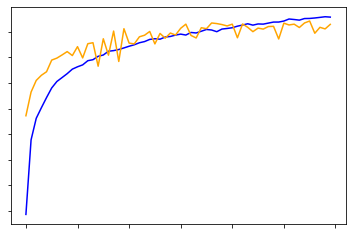

In [367]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(historyAug.history['loss'], color='blue', label='train')
plt.plot(historyAug.history['val_loss'], color='orange', label='test')
plt.show()


# plot accuracy
plt.title('Classification Accuracy')
plt.plot(historyAug.history['accuracy'], color='blue', label='train')
plt.plot(historyAug.history['val_accuracy'], color='orange', label='test')
plt.show()



**PART 2: Classic Machine Learning Algorithms: KNN and Random Forest**

In the below cells, I am doing image classification on the same dataset but this time using classic machine learning algorithms. I will also do data augmentation on these, and dataset expansion (x2 and x3). I will compare the models, as well as how they performed compared to the CNN.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In the below cell, I am multiplying the X training and testing sets and augmenting them to use them to test on my models in the future. Because of the different ways that CNNs and classic machine algorithms work, and that you are unable to call fit_generator and you do not give a batch size when fitting, I had to use a work around to augment the dataset. 

In [18]:
datagen = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)

xtrainCopyx2 = np.concatenate((xtrainCopy, xtrainCopy))
ytrainCopyx2 = np.concatenate((ytrainCopy, ytrainCopy))
xtrainCopyx3 = np.concatenate((xtrainCopyx2, xtrainCopy))
ytrainCopyx3 = np.concatenate((ytrainCopyx2, ytrainCopy))

xtrainCopyx22d = xtrainCopyx2.reshape((xtrainCopyx2.shape[0], 28, 28, 1))

xtrainCopyx32d = xtrainCopyx3.reshape((xtrainCopyx3.shape[0], 28, 28, 1))

datagen.fit(xtrainCopyx22d)
iterator_train1 = datagen.flow(xtrainCopyx22d, ytrainCopyx2, batch_size=95040)
xtrainCopyAugx2 = iterator_train1[0][0].reshape((iterator_train1[0][0].shape[0], 784))
ytrainCopyAugx2 = iterator_train1[0][1]


datagen.fit(xtrainCopyx32d)
iterator_train3 = datagen.flow(xtrainCopyx32d, ytrainCopyx3, batch_size=142560)
xtrainCopyAugx3 = iterator_train3[0][0].reshape((iterator_train3[0][0].shape[0], 784))
ytrainCopyAugx3 = iterator_train3[0][1]

The first classic machine learning algorithm that I chose to attempt image classification with is KNN. 
I initially just used the default parameters, and with this, I achieved an accuracy on the testing set of 85%. Not bad.

In [149]:
knn_model = KNeighborsClassifier()
knn_model.fit(xtrainCopy, ytrainCopy)
knn_y_predict = knn_model.predict(xtestCopy)
knn_y_predict

array([6., 0., 4., ..., 4., 1., 4.])

In [169]:
print('Accuracy of KNN: %.3f' % (accuracy_score(ytestCopy, knn_y_predict) * 100))

Accuracy of KNN: 85.818


To tune the hyperparameters, I used a grid search. Because of the time it is taking to run KNN on the image data and the fact that grid search exhaustively searches the parameters, I selected the parameters that I thought would be appropriate for this model and searched from there. 
I used 3 fold cross validation for the grid search.


In [19]:
gridParamsKNN  =  {
    'n_neighbors': [3, 5,11,19],
    'weights': ['uniform',  'distance'],
    'metric': ['euclidean', 'manhattan']
}

gsKNN = GridSearchCV(
    KNeighborsClassifier(),
    gridParamsKNN,
    cv = 3
)

gsResultsKNN = gsKNN.fit(xtrainCopy, ytrainCopy)

In [20]:
gsResultsKNN.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [21]:
gsResultsKNN.best_score_

0.8538299663299663

Now that I have found the best parameters from grid search, I need to re-run KNN with these new parameters, I need to use these parameters on the test set. After running it with the new hyperparameters, the accuracy went up from 85.8% to 86.3% (shown below). A small improvement, but not a significant difference. The default parameter for k is 5, and we found that the best parameter for k n_neihbors is also 5, so we can expect that our variance did not change much, as increasing k would likely decrease variance and visa versa. This could be part of the reason why our accuracy increased slightly by changing the weight to distance, but not much. 

This accuracy is a lot lower than my improved model from Q1, which had an accuracy of 93.8. But this is to be expected as CNNs are the proper way to do image classification.

In [151]:
knn_model2 = KNeighborsClassifier(n_neighbors= 5, weights= 'distance')
knn_model2.fit(xtrainCopy, ytrainCopy)
knn_y_predict2 = knn_model2.predict(xtestCopy)

In [173]:
print('Accuracy of KNN w/ Hyperparameters: %.3f' % (accuracy_score(ytestCopy, knn_y_predict2) * 100))

Accuracy of KNN w/ Hyperparameters: 86.250


x2 Augmented Data:
Below I am running KNN with tuned hyperparameters on my x2 augmented data. The accuracy actually decreased by several percent with the augmented data.

In [153]:
knn_model2_x2 = KNeighborsClassifier(n_neighbors= 5, weights= 'distance')
knn_model2_x2.fit(xtrainCopyAugx2, ytrainCopyAugx2)
knn_y_predict2_x2 = knn_model2_x2.predict(xtestCopy)
accuracy_score(ytestCopy, knn_y_predict2_x2)

0.8236111111111111

In [174]:
print('Accuracy of KNN w/ Hyperparameters and x2 Augmented Data: %.3f' % (accuracy_score(ytestCopy, knn_y_predict2_x2) * 100))

Accuracy of KNN w/ Hyperparameters and x2 Augmented Data: 82.361


x3 Augmented Data: Here I am runnning KNN with tuned hyperparameters on my x3 augmented data. The accuracy increased slightly from x2, but is still lower than the non-augmented data.

In [159]:
knn_model2_x3 = KNeighborsClassifier(n_neighbors= 5, weights= 'distance')
knn_model2_x3.fit(xtrainCopyAugx3, ytrainCopyAugx3)
knn_y_predict2_x3 = knn_model2_x3.predict(xtestCopy)
accuracy_score(ytestCopy, knn_y_predict2_x3)

0.8341049382716049

In [175]:
print('Accuracy of KNN w/ Hyperparameters and x3 Augmented Data: %.3f' % (accuracy_score(ytestCopy, knn_y_predict2_x3) * 100))

Accuracy of KNN w/ Hyperparameters and x3 Augmented Data: 83.410


For my second model, I am using Random Forest. With the parameters at their default, the accuracy of the model was 85.59%.

In [119]:
RFclf = RandomForestClassifier()
RFclf.fit(xtrainCopy, ytrainCopy)
ypred = RFclf.predict(xtestCopy)
accuracy_score(ytestCopy, ypred)

/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8558641975308642

In [177]:
print('Accuracy of Random Forest: %.3f' % (accuracy_score(ytestCopy, ypred) * 100))

Accuracy of Random Forest: 85.586


To tune the hyperparameters of Random Forest, I decided use another grid search. I was only able to tune the n_estimators parameter because of how long it was taking to run. N_estimators is the number of trees. Given more time, I would choose to search through more parameters such as max_depth which could possibly descrease the correlation between trees, but would do so carefully because it is at the cost of increasing bias. I could have also potentially looked into doing a randomized search so it is not exhaustive like grid search.
For my grid search, again, I used a cross validation of 3.

In [107]:
parameters = {
    'n_estimators'      : [320,330,340]
}

In [110]:
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=3)
clf.fit(xtrainCopy, ytrainCopy)

print(clf.score(xtrainCopy, ytrainCopy))
print(clf.best_params_)
print(clf.best_score_)


1.0
{'n_estimators': 320, 'random_state': 0}
0.878030303030303


Now running random forest with the tuned parameters, fit to my training set, my testing accuracy went from 85.59% to 88.1% - a pretty good. improvement! This is likely not related to over fitting as bias and variance are generally not a huge factor in random forest. The reason for this is random forest works by combining lots of high variance and low bias trees to generate a low bias-low variance forest.

Again, though, this was about 5% lower than the accuracy of my improved CNN model from Q1, which is to be expected as CNNs are optimal for image analyzing and classification. It is however better than my KNN algorithm results.

In [138]:
rfc = RandomForestClassifier(n_estimators = 320, random_state = 0)
rfc.fit(xtrainCopy, ytrainCopy)
rfc_pred = rfc.predict(xtestCopy)
accuracy_score(ytestCopy, rfc_pred)

0.8816358024691358

In [179]:
print('Accuracy of Random Forest with tuned parameters: %.3f' % (accuracy_score(ytestCopy, rfc_pred) * 100))

Accuracy of Random Forest with tuned parameters: 88.164


Below, I am running Random forest with tuned params on the x2 augmented data.

In [144]:
rfc = RandomForestClassifier(n_estimators = 320, random_state = 0)
rfc.fit(xtrainCopyAugx2, ytrainCopyAugx2)
rfc_pred_x2 = rfc.predict(xtestCopy)
accuracy_score(ytestCopy, rfc_pred_x2)

0.8359567901234568

In [182]:
print('Accuracy of Random Forest with tuned parameters and x2 Augmented Data: %.3f' % (accuracy_score(ytestCopy, rfc_pred_x2) * 100))

Accuracy of Random Forest with tuned parameters and x2 Augmented Data: 83.596


And the same for x3...

In [160]:
rfc = RandomForestClassifier(n_estimators = 320, random_state = 0)
rfc.fit(xtrainCopyAugx3, ytrainCopyAugx3)
rfc_pred_x3 = rfc.predict(xtestCopy)
accuracy_score(ytestCopy, rfc_pred_x3)

0.8421296296296297

I saw the same result here as I did with knn. When adding the augmented data (x2), it lowered the accuracy by several percent, and then it increased a little with x3, but not to as high as it was without augmentation.

It is evident that CNNs work different with images and augmented data than classic maching learning algorithms, as the validation accuracy of the CNNS increased with the augmented data from 93.7 to 94.58.

This is likely due to how CNN does image processing and how it "learns". 

CNNs recognize images with feature maps. Each of the maps will typically learn to extract a different feature from the image. So it looks at images more as a whole. Thus, having augmented data will only improve the way in which it will learn. Regular machine learning algorithms, on the other hand, do not learn images in this way. Instead it wil compare the values of each indivdual pixel. So augmenting the data, especially, when we have a pretty structured set of image data, may not help it learn as well, it may decrease it, which makes sense. It also makes sense, then, that x3 helps it to improve a little bit as we are more likely to have more images that are less augmented and closer to our test set of images.

In [183]:
print('Accuracy of Random Forest with tuned parameters and x3 Augmented Data: %.3f' % (accuracy_score(ytestCopy, rfc_pred_x3) * 100))

Accuracy of Random Forest with tuned parameters and x3 Augmented Data: 84.213


**PART 3: Predictions using the 3 models - CNN, KNN, Random Forest**

Here I will generate a csv file of my predictions

In [356]:
xnew = np.loadtxt('xnew.csv')
xnew.shape

(1080, 784)

In [357]:
xnew = xnew.reshape(len(xnew), 28, 28, 1) 
xnew /= 255.0

In [358]:
ynew = modelAug.predict_classes(xnew)

In [359]:
ynew = ynew + minClass

In [360]:
xnew = xnew.reshape(len(xnew), 784) 

In [361]:
knn_pred_ynew = knn_model2.predict(xnew)

In [362]:
rfc_pred_ynew = rfc.predict(xnew)

In [363]:
knn_pred_ynew += minClass
rfc_pred_ynew += minClass

In [364]:
data = {'CNN':  ynew,
        'kNN': knn_pred_ynew,
        'RF': rfc_pred_ynew,
        }

df = pd.DataFrame (data, columns = ['CNN','kNN','RF'])

In [365]:
df.to_csv('emily_daskas_classification_predictions.csv')